# Robust Varibad Analysis

In [1]:
%reload_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import cross_entropy_sampler as cem
import general_utils as utils
import analysis

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:90% !important; }</style>"))
np.set_printoptions(precision=4)
np.set_printoptions(linewidth=150)
np.set_printoptions(suppress=True)

/tmp/ipykernel_3008163/867683384.py:13: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


## Configuration

In [2]:
ENV_NAME = 'HalfCheetahVel-v0'
TITLE = ENV_NAME[:-3]
ENV_SHORT = 'hcv'
TASKS = ('v_goal',)
TASK_DIM = len(TASKS)
METHODS = ('varibad', 'cembad', 'cvrbad')
NM_MAP = dict(varibad='VariBAD', cvrbad='CVaR-ML', cembad='RoML')
SEEDS = list(range(15))  # 30
ALPHA = 0.05

### The CEM

In [3]:
TRANSFORMATION = lambda x: 7*x
YLIM = (0, 7)
SMOOTH = 20
CEM_SEED = 10

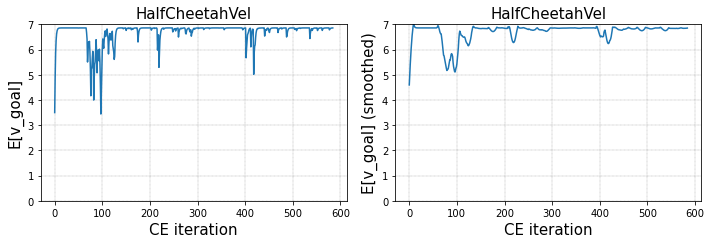

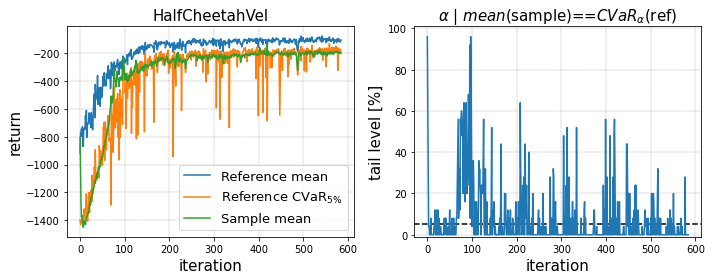

In [4]:
ce, c1, c2, axs1, axs2 = analysis.cem_analysis(
    ENV_NAME, TASK_DIM, TRANSFORMATION, YLIM, SMOOTH, title=TITLE, tasks=TASKS, seed=CEM_SEED)
plt.sca(axs1[0])
plt.savefig(f'outputs/{ENV_SHORT}_sample_dist.png', bbox_inches='tight', dpi=300)
plt.sca(axs2[0])
plt.savefig(f'outputs/{ENV_SHORT}_cem.png', bbox_inches='tight', dpi=300)

## Test results

In [5]:
%%time
rr, rra, rrm, rrc, rr0, rra0 = analysis.load_test_data(
    ENV_NAME, ENV_SHORT, METHODS, SEEDS, ALPHA, 'best', nm_map=NM_MAP)
rr

Test tasks: 1008
CPU times: user 46.4 s, sys: 263 ms, total: 46.7 s
Wall time: 46.7 s


,ep,ret,task0,method,seed
0,0,-127.797058,5.707809,VariBAD,0
1,1,-132.149750,5.707809,VariBAD,0
2,0,-203.905289,6.997781,VariBAD,0
3,1,-224.612717,6.997781,VariBAD,0
4,0,-21.998009,1.272675,VariBAD,0
...,...,...,...,...,...
90715,1,-64.090340,0.249678,CVaR-ML,14
90716,0,-62.682983,0.275216,CVaR-ML,14
90717,1,-66.781677,0.275216,CVaR-ML,14
90718,0,-201.520493,0.957760,CVaR-ML,14


Test returns vs. task - over all seeds aggregated:
CPU times: user 1.1 s, sys: 4.09 ms, total: 1.1 s
Wall time: 1.1 s


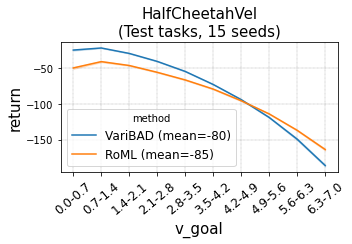

In [6]:
%%time
axs = analysis.show_test_vs_tasks(rra[rra.method!='CVaR-ML'], None, TITLE, TASKS, min_ndigits=1)
plt.savefig(f'outputs/{ENV_SHORT}_tasks.png', bbox_inches='tight', dpi=300)

In [7]:
# if FINISHED:
#     axs = analysis.summarize_test(rra0, rr0, ALPHA)

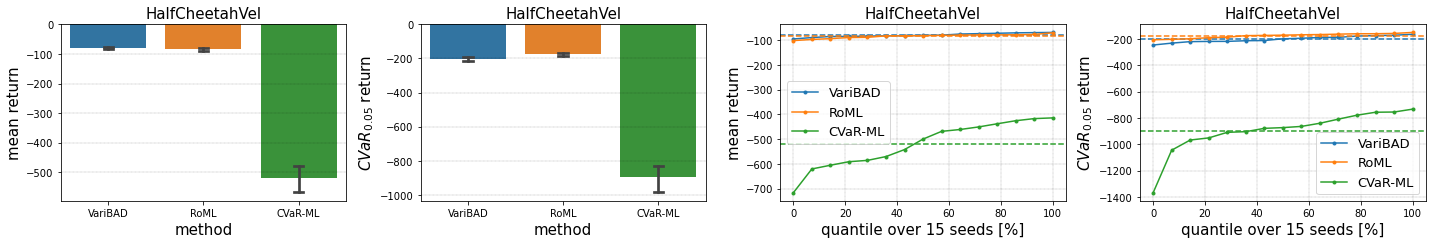

In [8]:
axs = analysis.summarize_test_over_seeds(rrm, rrc, ALPHA, TITLE, barplot=True)

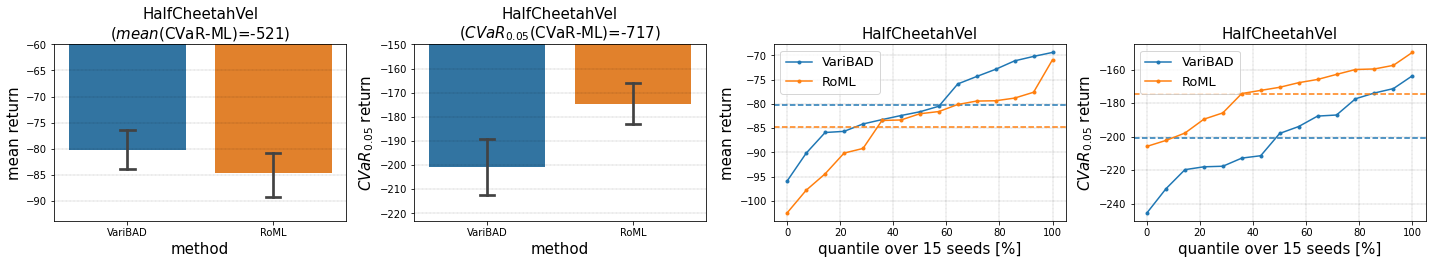

In [9]:
axs = analysis.summarize_test_over_seeds(rrm[rrm.method!='CVaR-ML'], rrc[rrc.method!='CVaR-ML'], ALPHA, TITLE, barplot=True)
axs[0].set_title(f'{TITLE}\n($mean$(CVaR-ML)={rrm.ret[rrm.method=="CVaR-ML"].mean():.0f})', fontsize=15)
axs[0].set_ylim((None, -60))
axs[1].set_title(f'{TITLE}\n($CVaR_{{{ALPHA}}}$(CVaR-ML)={analysis.get_cvar_fun(ALPHA)(rrm.ret[rrm.method=="CVaR-ML"]):.0f})', fontsize=15)
axs[1].set_ylim((None, -150))
plt.savefig(f'outputs/{ENV_SHORT}_summary.png', bbox_inches='tight', dpi=300)

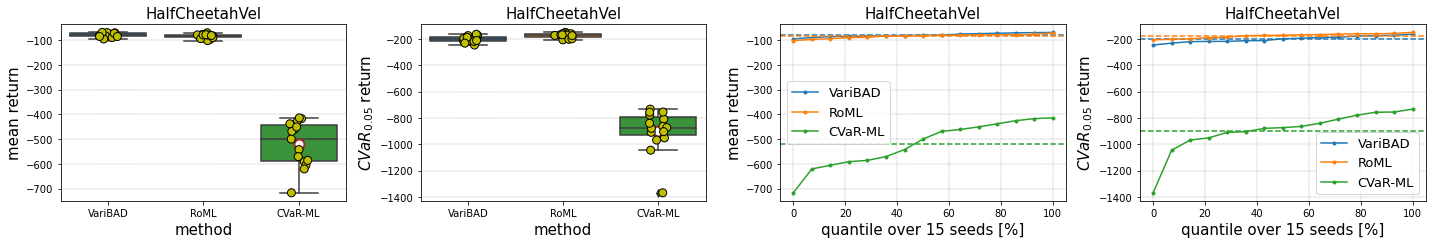

In [10]:
axs = analysis.summarize_test_over_seeds(rrm, rrc, ALPHA, TITLE)

### Final models test (not best over validation)

Test tasks: 1008
Test returns vs. task - over all seeds aggregated:
CPU times: user 48.2 s, sys: 360 ms, total: 48.6 s
Wall time: 48.6 s


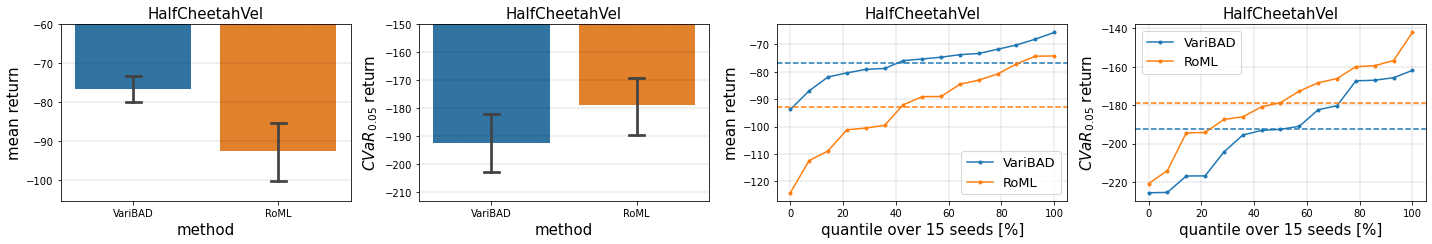

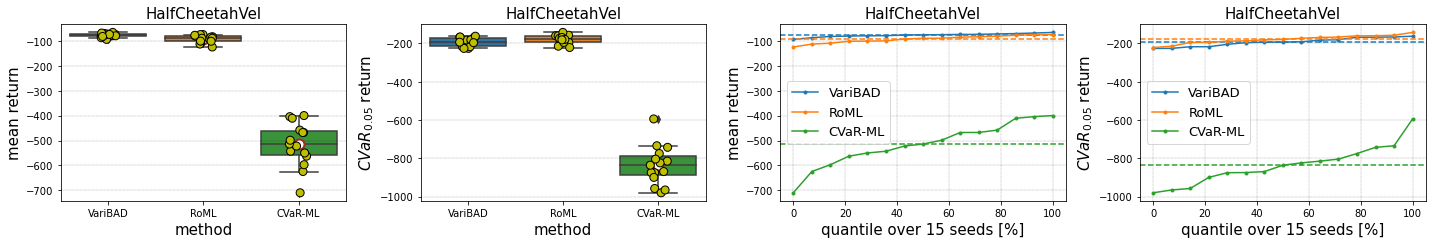

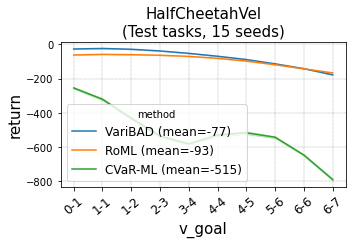

In [11]:
%%time
bb, bba, bbm, bbc, bb0, bba0 = analysis.load_test_data(
    ENV_NAME, ENV_SHORT, METHODS, SEEDS, ALPHA, 'final', nm_map=NM_MAP)

axs = analysis.summarize_test_over_seeds(bbm[bbm.method!='CVaR-ML'], bbc[bbc.method!='CVaR-ML'], ALPHA, TITLE, barplot=True)
axs[0].set_ylim((None, -60))
axs[1].set_ylim((None, -150))
plt.savefig(f'outputs/{ENV_SHORT}_f_summary.png', bbox_inches='tight', dpi=300)

axs = analysis.summarize_test_over_seeds(bbm, bbc, ALPHA, TITLE)
axs2 = analysis.show_test_vs_tasks(bba, bba0, TITLE, TASKS)

## Validation results

In [12]:
%%time
dd, dda, ddm, ddc, dd0, dda0, task_dim = analysis.load_train_data(
    ENV_NAME, ENV_SHORT, METHODS, SEEDS, ALPHA, nm_map=NM_MAP)
dd

hcv_varibad_0__27:10_20:14:58
hcv_varibad_1__28:10_05:07:33
hcv_varibad_2__28:10_14:12:39
hcv_varibad_3__28:10_23:17:28
hcv_varibad_4__29:10_08:24:24
hcv_varibad_5__29:10_17:29:49
hcv_varibad_6__30:10_01:34:48
hcv_varibad_7__30:10_10:40:32
hcv_varibad_8__30:10_19:32:42
hcv_varibad_9__31:10_03:21:28
hcv_varibad_10__19:11_15:14:48
hcv_varibad_11__20:11_00:13:28
hcv_varibad_12__20:11_09:11:26
hcv_varibad_13__20:11_18:10:06
hcv_varibad_14__21:11_03:07:52
hcv_cembad_0__27:10_20:15:00
hcv_cembad_1__28:10_05:12:08
hcv_cembad_2__28:10_14:22:13
hcv_cembad_3__28:10_23:31:55
hcv_cembad_4__29:10_08:42:46
hcv_cembad_5__29:10_17:54:28
hcv_cembad_6__30:10_02:03:52
hcv_cembad_7__30:10_11:14:43
hcv_cembad_8__30:10_20:06:43
hcv_cembad_9__31:10_04:00:04
hcv_cembad_10__19:11_15:14:32
hcv_cembad_11__20:11_00:15:54
hcv_cembad_12__20:11_09:16:34
hcv_cembad_13__20:11_18:19:37
hcv_cembad_14__21:11_03:20:38
hcv_cvrbad_0__09:12_17:33:33
hcv_cvrbad_1__10:12_02:04:18
hcv_cvrbad_2__10:12_10:35:05
hcv_cvrbad_3__10:1

,iter,task_id,ep,ret,task0,method,seed
0,-1,0,0,-106.341248,0.360242,VariBAD,0
1,-1,0,1,-136.573456,0.360242,VariBAD,0
2,-1,1,0,-193.122650,0.846701,VariBAD,0
3,-1,1,1,-185.777267,0.846701,VariBAD,0
4,-1,2,0,-538.239807,2.438226,VariBAD,0
...,...,...,...,...,...,...,...
270715,4674,13,1,-642.808105,4.612710,CVaR-ML,14
270716,4674,14,0,-994.767578,6.988574,CVaR-ML,14
270717,4674,14,1,-998.481323,6.988574,CVaR-ML,14
270718,4674,15,0,-969.353821,6.225567,CVaR-ML,14


In [13]:
# axs = analysis.show_task_distribution(dda0, rra0, TASKS)

In [14]:
# %%time
# axs = analysis.show_validation_vs_tasks(dda, TASKS)

In [15]:
# %%time
# axs = analysis.show_validation_results(dda0, ALPHA)

CPU times: user 219 ms, sys: 4.03 ms, total: 223 ms
Wall time: 222 ms


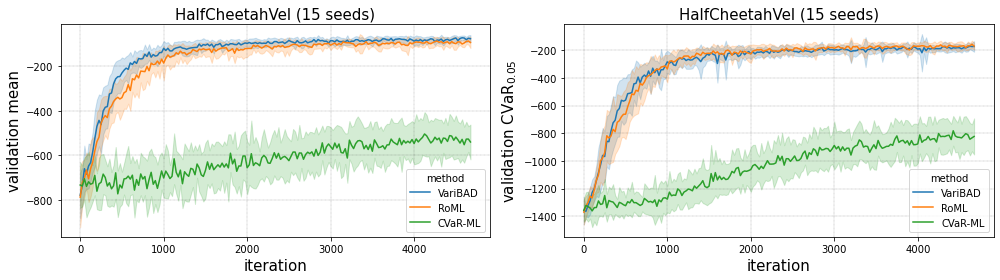

In [16]:
%%time
axs = analysis.show_validation_results_over_seeds(ddm, ddc, ALPHA, TITLE)

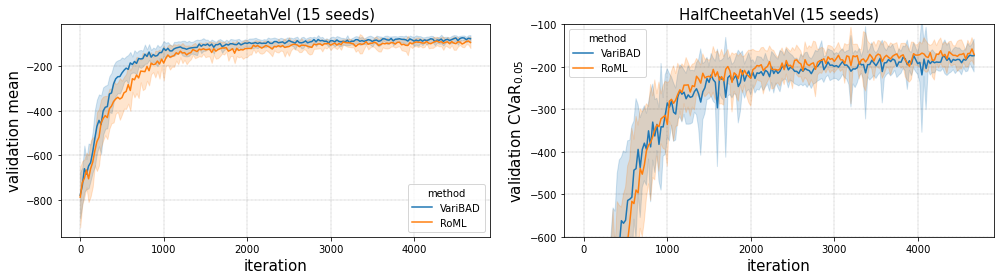

In [18]:
axs = analysis.show_validation_results_over_seeds(ddm[ddm.method!='CVaR-ML'], ddc[ddc.method!='CVaR-ML'], ALPHA, TITLE)
axs[1].set_ylim((-600,-100))
plt.savefig(f'outputs/{ENV_SHORT}_valid.png', bbox_inches='tight', dpi=300)